In [2]:
import psycopg2
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from tqdm.notebook import tqdm_notebook as tqdm
from collections import OrderedDict

import json
import statistics

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_absolute_error

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12, 4

import pickle

%matplotlib inline

tqdm.pandas()

pd.options.display.max_columns = None

/Users/tim/miniconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
with open('config.json') as file:
    config = json.load(file)
    host = config['host']
    database = config['database']
    user = config['user']
    password = config['password']
engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{database}')

In [4]:
input_data = pickle.load(open('exploded.pickle', 'rb'))

In [5]:
all_data = input_data["x"]
discharge_days = input_data["y"]
admt_ids = input_data['admt_ids']

In [6]:
rxs = ['?', 'DILAUDID', 'HEPARIN SODIUM', 'KEFZOL / ANCEF', 'TORADOL', 'VERSED', 'PEPCID', 'LACTATED RINGERS', 'HEPARIN', 'VALIUM', 'ROXICODONE','0.9 % SODIUM CHLORIDE', 'HumaLOG', 'SUBLIMAZE', 'NEURONTIN', 'FENTANYL', 'MORPHINE SULFATE', 'TYLENOL ES','PHENERGAN', 'LACTATED RINGERS SOLN 1000 ML','TYLENOL EXTRA STRENGTH', 'Transderm-Scop','PROTONIX', 'PERCOCET 5/325 MG', 'COLACE','NORCO 5/325', 'ANCEF','SODIUM CHLORIDE 0.9%', 'NACL-0.9%','MORPHINE', 'DILAUDID (iSECURE SYRINGE)','ULTRAM', 'LIPITOR','NORMAL SALINE FLUSH 10ML SYRINGE', 'LOVENOX','LOPRESSOR', 'MOTRIN', 'APRESOLINE','ROBAXIN', 'TYLENOL EXTRA STRENGH','ROXICODONE 5 MG IR TAB', 'ZOFRAN ODT','CeleBREX', 'ROCEPHIN', 'LYRICA','ISOVUE-370', 'fentaNYL CITRATE', 'ZOFRAN','TylenoL']
pxs = ['Ropivacaine hcl injection','Ondansetron hcl injection', 'ROUTINE VENIPUNCTURE', 'Dexamethasone sodium phos','METABOLIC PANEL TOTAL CA', 'Inj, propofol, 10 mg','Compounded drug, noc', 'Inj midazolam hydrochloride','ELECTROCARDIOGRAM TRACING','Anchor/screw bn/bn,tis/bn','Drugs unclassified injection','EMERGENCY DEPT VISIT', 'Fentanyl citrate injection','Inj heparin sodium per 1000u','Hospital observation per hr','THER/PROPH/DIAG INJ IV PUSH', 'Guide wire','Cefazolin sodium injection','Normal saline solution infus','Neostigmine methylslfte inj', 'HEMOGLOBIN','ASSAY OF LIPASE', 'Insulin injection','Morphine sulfate injection','Vancomycin hcl injection', 'ASSAY OF TROPONIN QUANT','TISSUE EXAM BY PATHOLOGIST','Intro/sheath, non-laser', 'COMPLETE CBC AUTOMATED','URINALYSIS AUTO W/SCOPE','Ketorolac tromethamine inj', 'Catheter, guiding','ASSAY OF MAGNESIUM', 'FLUOROSCOPY <1 HR PHYS/QHP','X-RAY EXAM CHEST 1 VIEW', 'RBC ANTIBODY SCREEN','BLOOD TYPING SEROLOGIC ABO','Locm 300-399mg/ml iodine,1ml','COMPREHEN METABOLIC PANEL', 'HEMATOCRIT','THROMBOPLASTIN TIME PARTIAL','BLOOD TYPING SEROLOGIC RH(D)', 'PROTHROMBIN TIME','Hydromorphone injection','Joint device (implantable)','Ringers lactate infusion','CULTURE OTHR SPECIMN AEROBIC','TX/PRO/DX INJ NEW DRUG ADDON','ASSAY OF LACTIC ACID']
vitals = ["systolic", "diastolic", "temperature_c", "weight_kg", "oxygen_levels", "pulse"]

filtered_rx_keys = [f"rx_{rx}" for rx in rxs[:16]]
filtered_px_keys = [f"px_{px}" for px in pxs[:19]]
features_to_look_at = np.array(filtered_rx_keys + filtered_px_keys + vitals)

In [7]:
def train_model(starting_day=0, **input_params):
    all_encounters = []
    days_left = []
    selected_admt_ids = []
    for i, df in enumerate(tqdm(all_data)):
        if discharge_days[i] - starting_day > 0:
            feature_data = [admt_ids[i]]
            for col in df:
                if col in features_to_look_at:
                    sum_of_col = df[col].sum()
                    if col in vitals:
                        sum_of_col /= len(df)
                    feature_data.append(sum_of_col)
            all_encounters.append(feature_data)
            days_left.append(discharge_days[i] - starting_day)
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(all_encounters)
    y = days_left

    test_size = 0.2
    seed = 5

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    
    admt_selector = np.full((1, len(X_train[0])), False)
    admt_selector[0][0] = True
    
    X_train_unscaled = scaler.inverse_transform(X_test)
    test_admt_ids = np.array(X_train_unscaled)[:, admt_selector[0]]
    

    X_train = np.array(X_train)[:, ~admt_selector[0]]
    X_test = np.array(X_test)[:, ~admt_selector[0]]
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    base_params = {
        'max_depth': 6, # try 7 (2^7), traing until error_train diverges error_test (error_test will be higher when overfit)
        'n_estimators': 500, # try 50, [500], 1000, 5000, higher = likely to overtrain
        'eta': 0.3,
        "objective": "reg:squarederror",
        'nthread': 4
    }
    
    params = { **base_params, **input_params }

    model = XGBClassifier(**params)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(np.array(X_test))
    
    # Compute MAE
    mae_baseline = mean_absolute_error(y_test, y_pred)
    print("MAE is {:.2f}".format(mae_baseline))
    
    return (model, test_admt_ids, y_test, y_pred, mae_baseline)

In [8]:
day = 0
base_model, ids, actual, predictions, mae = train_model(day)


MAE is 1.93


In [9]:
inaccurate_admt_ids = {}

for i, admt_id in enumerate(ids):
    actual_los = actual[i]
    predicted_los = predictions[i]
    if (abs(actual_los - predicted_los) > mae):
        inaccurate_admt_ids[format(admt_id[0], ".64g")] = {
            "actual_los": actual_los,
            "predicted_los": predicted_los,
            "i": i
        }

print(f"Predictions over MAE: {len(inaccurate_admt_ids)} out of {len(ids)} ({(len(inaccurate_admt_ids)/len(ids)) * 100}%)")

Predictions over MAE: 635 out of 2742 (23.158278628738145%)


In [181]:
def split_blood_pressure(blood_pressures):
    systolics = []
    diastolics = []
    for blood_pressure in blood_pressures:
        if blood_pressure is None:
            continue
        split = blood_pressure.split('/')
        systolics.append(int(split[0]))
        diastolics.append(int(split[1]))
    return (systolics, diastolics)

def explode_encounter(admission_id, current_los):
    demo_query = f"""
    select * from ms_demographicss md
    where md."AdmtID" = {admission_id}
    """
    demo_df = pd.read_sql_query(demo_query, engine)
    rx_query = f"""
    select * from ms_inpatient_pharm mip
    where mip."AdmtID" = {admission_id}
    and mip."Rel_Admin_Date" <= {current_los}
    """
    rx_df = pd.read_sql_query(rx_query, engine)
    px_query = f"""
    select * from ms_procedures mp
    where mp."AdmtID" = {admission_id}
    and mp."Rel_Service_Day" <= {current_los}
    """
    px_df = pd.read_sql_query(px_query, engine)
    vitals_query = f"""
    select * from ms_vitals mv 
    where mv."AdmtID" = {admission_id}
    and mv."Vital_Rel_Day" <= {current_los}
    """
    vitals_df = pd.read_sql_query(vitals_query, engine)
    
    days = []
    
    for day in range(current_los + 1):
        rxs_for_day = rx_df[rx_df['Rel_Admin_Date'] == day]['Med'].values
        rx_dict = {}
        
        for rx in rxs:
            rx_dict[f"rx_{rx}"] = 1 if rx in rxs_for_day else 0
        
        pxs_for_day = px_df[px_df['Rel_Service_Day'] == day]['PX_Desc'].values
        px_dict = {}
        
        for px in pxs:
            px_dict[f"px_{px}"] = 1 if px in pxs_for_day else 0
            
        vitals_for_day = vitals_df[vitals_df['Vital_Rel_Day'] == day]
        bp_for_day = vitals_for_day[vitals_for_day['Vital_Id_Txt'] == 'Blood pressure:']['Vital_Result_Value_Txt'].values
        systolics_for_day, diastolics_for_day = split_blood_pressure(bp_for_day)
        
        temperature_c_for_day = list(vitals_for_day[vitals_for_day['Source_System_Original_Code'] == 'K33010002A']['Vital_Result_Value_Txt'].astype(float).values)
        temperature_f_for_day = list(vitals_for_day[vitals_for_day['Source_System_Original_Code'] == 'K33010003A']['Vital_Result_Value_Txt'].astype(float).values)
        temperature_c_for_day.extend(list(map(lambda f: (f - 32) * (5/9), temperature_f_for_day)))
        
        weight_kg_for_day = list(vitals_for_day[vitals_for_day['Source_System_Original_Code'] == 'K31010003A']['Vital_Result_Value_Txt'].astype(float).values)
        weight_lb_for_day = list(vitals_for_day[vitals_for_day['Source_System_Original_Code'] == 'K31010001A']['Vital_Result_Value_Txt'].astype(float).values)
        weight_kg_for_day.extend(list(map(lambda lb: lb / 2.205, weight_lb_for_day)))
        
        oxygen_levels_for_day = list(vitals_for_day[vitals_for_day['Source_System_Original_Code'] == 'L35010001A']['Vital_Result_Value_Txt'].astype(float).values)
        pulse_for_day = list(vitals_for_day[vitals_for_day['Source_System_Original_Code'] == 'K33010006A']['Vital_Result_Value_Txt'].astype(float).values)
        
        systolic = statistics.mean(systolics_for_day) if len(systolics_for_day) > 0 else -1
        diastolic = statistics.mean(diastolics_for_day) if len(diastolics_for_day) > 0 else -1
        temperature_c = statistics.mean(temperature_c_for_day) if len(temperature_c_for_day) > 0 else -1
        weight_kg = statistics.mean(weight_kg_for_day) if len(weight_kg_for_day) > 0 else -1
        oxygen_levels = statistics.mean(oxygen_levels_for_day) if len(oxygen_levels_for_day) > 0 else -1
        pulse = statistics.mean(pulse_for_day) if len(pulse_for_day) > 0 else -1
        
        vitals_dict = {
            "systolic": systolic,
            "diastolic": diastolic,
            "temperature_c": temperature_c,
            "weight_kg": weight_kg,
            "oxygen_levels": oxygen_levels,
            "pulse": pulse
        }
        
        days.append({
            **rx_dict,
            **px_dict,
            **vitals_dict
        })

    return pd.DataFrame.from_records(days)

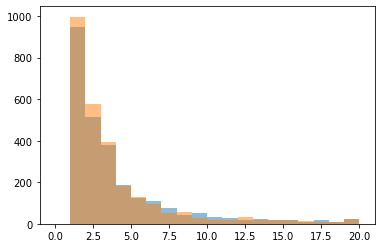

In [136]:
hist_params = {
    "range": (0, 20),
    "bins": 20,
    "alpha": 0.5
}

plt.hist(actual, **hist_params)
plt.hist(predictions, **hist_params)

plt.show()

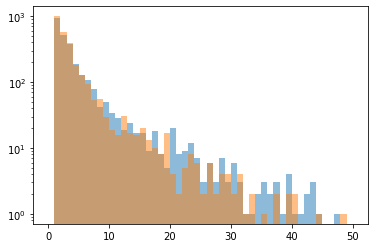

In [208]:
hist_params = {
    "range": (0, 50),
    "bins": 50,
    "alpha": 0.5,
    "log": True
}

plt.hist(actual, **hist_params)
plt.hist(predictions, **hist_params)

plt.show()

In [188]:
def get_events_from_encounter(admission_id, current_los):
    demo_query = f"""
    select * from ms_demographicss md
    where md."AdmtID" = {admission_id}
    """
    demo_df = pd.read_sql_query(demo_query, engine)
    rx_query = f"""
    select * from ms_inpatient_pharm mip
    where mip."AdmtID" = {admission_id}
    and mip."Rel_Admin_Date" >= {current_los}
    """
    rx_df = pd.read_sql_query(rx_query, engine)
    px_query = f"""
    select * from ms_procedures mp
    where mp."AdmtID" = {admission_id}
    and mp."Rel_Service_Day" >= {current_los}
    """
    px_df = pd.read_sql_query(px_query, engine)
    vitals_query = f"""
    select * from ms_vitals mv 
    where mv."AdmtID" = {admission_id}
    and mv."Vital_Rel_Day" >= {current_los}
    """
    vitals_df = pd.read_sql_query(vitals_query, engine)
    
    events = {
        "rx": rx_df['Med'].unique(),
        "px": px_df['PX_Desc'].unique()
    }
    
    return events

In [202]:
finds = []

for key in inaccurate_admt_ids.keys():
    query = f"""
    select * from ms_demographicss md
    where md."AdmtID" = {key}
    """
    df = pd.read_sql_query(query, engine)
    if len(df) > 0:
        finds.append(key)

percentage = format((len(finds)/len(inaccurate_admt_ids.keys())) * 100, ".2f")
print(f"Successfully found data on admissions: {len(finds)}, ({percentage}%)")

Successfully found data on admissions: 11, (1.73%)


In [206]:
inaccurate_dfs = []

for admt_id in tqdm(finds):
    if admt_id in inaccurate_admt_ids.keys():
        events = get_events_from_encounter(admt_id, day)
        inaccurate_dfs.append(events)
        print(admt_id)
        print(events)

190449000211921184
{'rx': array(['Heparin Lock Flush 10 Units/Ml'], dtype=object), 'px': array(['Plate pheres leukoredu irrad', 'BLOOD TYPE ANTIGEN DONOR EA',
       'Inj heparin sodium per 10 u', 'CYTOMEG DNA AMP PROBE',
       'BLOOD TRANSFUSION SERVICE', 'Pathogen test for platelets',
       'BLOOD TYPING SEROLOGIC RH(D)', 'BLOOD TYPING SEROLOGIC ABO',
       'RBC ANTIBODY SCREEN'], dtype=object)}
183589000151959712
{'rx': array(['BENADRYL', 'PARAPLATIN', 'PEPCID', 'ZOFRAN',
       '0.9 % SODIUM CHLORIDE', 'TAXOL (PACLITAXEL)', 'Cinvanti'],
      dtype=object), 'px': array(['INHIBIN A', 'Inj tbo filgrastim 1 microg',
       'CHEMO IV INFUS EACH ADDL SEQ', 'Inj., aprepitant, 1 mg',
       'CHEMO IV INFUSION 1 HR', 'TX/PROPH/DG ADDL SEQ IV INF',
       'Carboplatin injection', 'CHEMO IV INFUSION ADDL HR',
       'THER/PROPH/DIAG INJ SC/IM', 'IMMUNOASSAY QUANT NOS NONAB',
       'Paclitaxel injection', 'Injection, famotidine, 20 mg',
       'HYDRATE IV INFUSION ADD-ON', 'OFFICE/OUTPATI

190509000227972512
{'rx': array(['SOD BICARB 4.2% 5 MEQ SYRINGE', 'CAFFEINE CITRATE',
       'INTRALIPID 20% 50 ML IV', 'TROPHAMINE/DEXTROSE',
       'CALCIUM GLUCONATE 10%', 'DONOR BREASTMILK',
       'Heparin Lock Flush 10 Units/Ml', 'SOD CL 0.9% IV SOLN 250 ML',
       'MORPHINE SULFATE', 'AMPICILLIN SODIUM',
       'DEXTROSE 10%-WATER 250ML', 'TROPH 3% +CalGluc 1250MG +D10W',
       'TROPH 1% 1/4 NA ACET + 1:1 HEP 250 ML BAG', 'ATIVAN 2 MG/ML INJ'],
      dtype=object), 'px': array(['BLOOD GASES ANY COMBINATION', 'THROMBOPLASTIN TIME PARTIAL',
       'ASSAY OF SERUM POTASSIUM', 'ASSAY OF PROGESTERONE 17-D',
       'ASSAY OF BLOOD PKU', 'ASSAY OF BIOTINIDASE',
       'Insertion of Monitoring Device into Low Art, Perc Approach',
       'Caffeine citrate injection', 'BILIRUBIN TOTAL',
       'INSERTION OF TIVAD INTO CHEST SUBCU/FASCIA, OPEN APPROACH',
       'Inj heparin sodium per 10 u', 'ASSAY OF CALCIUM',
       'ASSAY OF UREA NITROGEN', 'ORGANIC ACIDS QUAL EACH',
       'ASSAY OF 

190239000152916320
{'rx': array(['LIPITOR', 'NASAL ANTISEPTIC SWABS', '?', 'PEPCID', 'VERSED',
       'NORMAL SALINE FLUSH 10ML SYRINGE', 'AMBIEN', 'NORCO 5/325',
       'TylenoL', 'SOLU-MedroL', 'BYSTOLIC', 'fentaNYL CITRATE',
       'LEXAPRO', 'DUONEB 2.5-0.5 MG/3 ML <GEN>', 'CATAPRES',
       'ISOVUE-300', 'CYKLOKAPRON', 'ADRENALIN'], dtype=object), 'px': array(['RADIATION TREATMENT DELIVERY', 'RADIATION THERAPY DOSE PLAN',
       'Beam Radiation of Lung using Electrons',
       'Drainage of Left Upper Lung Lobe, Endo, Diagn',
       '3-D RADIOTHERAPY PLAN', 'Locm 300-399mg/ml iodine,1ml',
       'GUIDANCE FOR RADJ TX DLVR', 'SET RADIATION THERAPY FIELD',
       'RADIATION TREATMENT AID(S)', 'COMPREHEN METABOLIC PANEL',
       'EXTRACTION OF LEFT UPPER LOBE BRONCHUS, ENDO, DIAGN',
       'CT THORAX W/DYE', 'Methylprednisolone injection',
       'EMERGENCY DEPT VISIT', 'CYTOPATH CELL ENHANCE TECH',
       'COMPLETE CBC AUTOMATED', 'METABOLIC PANEL IONIZED CA',
       'AIRWAY INHALATI

In [10]:
list(inaccurate_admt_ids.keys())

['190079000172015872',
 '190589000136991168',
 '190389000190928416',
 '190209000151937504',
 '183399000199955072',
 '190289000183997376',
 '190449000211921184',
 '190669000174949024',
 '190729000238949664',
 '190049000186954208',
 '190509000137891296',
 '190049000136924192',
 '190089000149051392',
 '190769000167003168',
 '190219000140984224',
 '190519000140947680',
 '190639000179979680',
 '190079000199930784',
 '190379000164940896',
 '190699000138990016',
 '190509000163932256',
 '190239000157035392',
 '190729000175904704',
 '190329000216945600',
 '190259000167018304',
 '190359000304940512',
 '190459000160954176',
 '190659000196969920',
 '190369000154968000',
 '190379000183931072',
 '190869000142007808',
 '190489000137894080',
 '190759000146832640',
 '190539000196994592',
 '190569000140000768',
 '190559000148934944',
 '190779000189984224',
 '190399000215972896',
 '190019000140909184',
 '190429000231909600',
 '190849000147996032',
 '190659000164995168',
 '183589000151959712',
 '190849000

<BarContainer object of 41 artists>

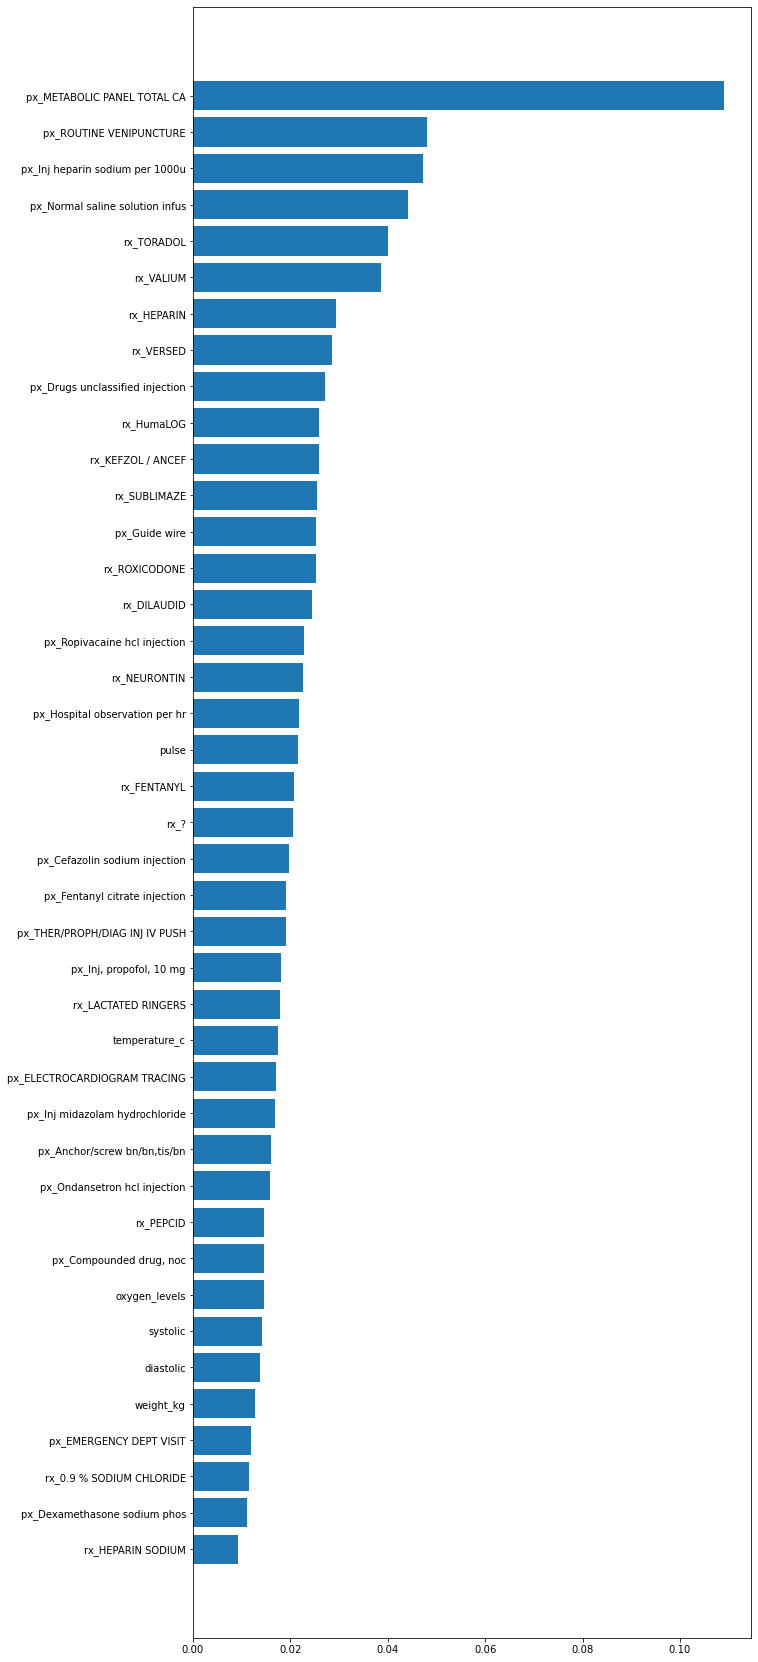

In [16]:
plt.figure(figsize=(10,30))
sorted_features = base_model.feature_importances_.argsort()
plt.barh(np.array(list(features_to_look_at))[sorted_features], base_model.feature_importances_[sorted_features])

In [11]:
# Look at diagnoses for the misses
    # bar chart of total days off per diagnoses
# 2D histogram
    # Actual LOS vs Predicted LOS
# (-20, 20) of error between actual and predicted

# Compare the ones that were really close to the ones that are really off
# Optimize the data/features first, then think about the hyperparameters
    # Just set reasonable parameters
    
# Diagnoses and reason for visit
    # Plot
    # Probability differences
        # What's the chance the accurate ones got a px/rx
        # What's the chance the wrong ones got a px/rx
        # Subtract the differences, look at the log, rank them, etc.
        

In [12]:
pickle.dump(list(inaccurate_admt_ids.keys()), open('over_mae.pickle', 'wb'))

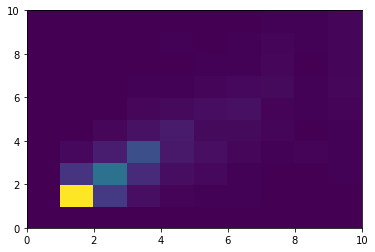

In [22]:
hist2d_params = {
#     "bins": [100, 100],
#     "density": True,
    "range": [[0, 10], [0, 10]]
}

plt.hist2d(actual, predictions, **hist2d_params)
plt.show()

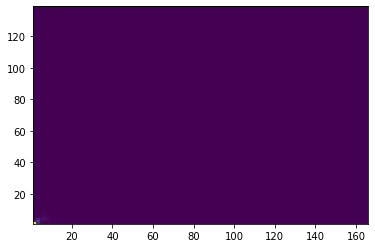

In [24]:
hist2d_params = {
    "bins": [100, 100],
#     "density": True,
#     "range": [[0, 10], [0, 10]]
}

plt.hist2d(actual, predictions, **hist2d_params)
plt.show()

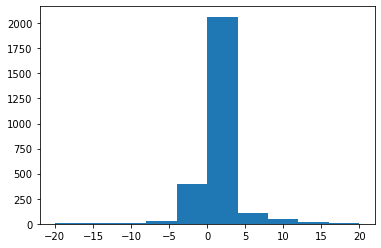

In [31]:
hist_params = {
    "range": (-20, 20)
}

plt.hist(actual - predictions, **hist_params)
plt.show()

In [ ]:
#Can't predict if there are no more days left